In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
from sklearn.model_selection import train_test_split
import tensorflow_datasets as tfds

dataset, info = tfds.load('kmnist', with_info=True, as_supervised=True)

full_dataset = dataset['train']

def preprocess_data(dataset):
    images = []
    labels = []
    for image, label in tfds.as_numpy(dataset):
        images.append(image)
        labels.append(label)
    return np.array(images), np.array(labels)

images, labels = preprocess_data(full_dataset)

# Normalize images to range [0, 1]
images = images.reshape(-1, 28*28) / 255.0

# Split the dataset into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

print(f'Training set shape: {X_train.shape}, Training labels shape: {y_train.shape}')
print(f'Test set shape: {X_test.shape}, Test labels shape: {y_test.shape}')

2024-10-19 08:53:47.407663: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-19 08:53:47.410300: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-19 08:53:47.417321: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-19 08:53:47.428200: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-19 08:53:47.431390: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-19 08:53:47.440825: I tensorflow/core/platform/cpu_feature_gu

Training set shape: (48000, 784), Training labels shape: (48000,)
Test set shape: (12000, 784), Test labels shape: (12000,)


In [2]:
def rbf(x, center, sigma=1.0):
    return np.exp(-np.linalg.norm(x - center) ** 2 / (2 * sigma ** 2))

class RBFNetwork:
    def __init__(self, num_rbf_units, num_classes):
        self.num_rbf_units = num_rbf_units
        self.num_classes = num_classes
        self.centers = None
        self.weights = None
        self.sigma = None

    def fit(self, X, y, learning_rate=0.01, epochs=100):
        kmeans = KMeans(n_clusters=self.num_rbf_units)
        kmeans.fit(X)
        self.centers = kmeans.cluster_centers_

        # Initialize weights randomly
        self.weights = np.random.randn(self.num_rbf_units, self.num_classes)

        # Using mean distance between centers as sigma
        d_max = np.max([np.linalg.norm(c1 - c2) for c1 in self.centers for c2 in self.centers])
        self.sigma = d_max / np.sqrt(2 * self.num_rbf_units)

        # One-hot encode labels
        y_one_hot = np.eye(self.num_classes)[y]

        # Training loop
        for epoch in range(epochs):
            # Compute RBF activations for each input
            G = np.zeros((X.shape[0], self.num_rbf_units))
            for i, x in enumerate(X):
                for j, c in enumerate(self.centers):
                    G[i, j] = rbf(x, c, self.sigma)

            # Forward pass (softmax)
            output = self.softmax(np.dot(G, self.weights))

            # Backpropagation (gradient descent)
            error = output - y_one_hot
            self.weights -= learning_rate * np.dot(G.T, error)

            loss = np.mean(np.square(error))
            print(f'Epoch {epoch}\n\tLoss: {loss}')

    # Predict function
    def predict(self, X):
        G = np.zeros((X.shape[0], self.num_rbf_units))
        for i, x in enumerate(X):
            for j, c in enumerate(self.centers):
                G[i, j] = rbf(x, c, self.sigma)

        output = self.softmax(np.dot(G, self.weights))
        return np.argmax(output, axis=1)

    # Softmax function
    def softmax(self, x):
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)


In [3]:
# Instantiate the RBF Network
num_rbf_units = 100
num_classes = 10
rbf_network = RBFNetwork(num_rbf_units=num_rbf_units, num_classes=num_classes)

# Train the model
rbf_network.fit(X_train, y_train, learning_rate=0.01, epochs=100)


Epoch 0
	Loss: 0.08999998984136087
Epoch 1
	Loss: 0.08999998983185695
Epoch 2
	Loss: 0.08999998982235308
Epoch 3
	Loss: 0.08999998981284918
Epoch 4
	Loss: 0.08999998980334531
Epoch 5
	Loss: 0.08999998979384136
Epoch 6
	Loss: 0.0899999897843374
Epoch 7
	Loss: 0.0899999897748335
Epoch 8
	Loss: 0.0899999897653296
Epoch 9
	Loss: 0.08999998975582567
Epoch 10
	Loss: 0.08999998974632172
Epoch 11
	Loss: 0.0899999897368178
Epoch 12
	Loss: 0.08999998972731384
Epoch 13
	Loss: 0.08999998971780994
Epoch 14
	Loss: 0.08999998970830594
Epoch 15
	Loss: 0.08999998969880196
Epoch 16
	Loss: 0.08999998968929804
Epoch 17
	Loss: 0.0899999896797941
Epoch 18
	Loss: 0.08999998967029013
Epoch 19
	Loss: 0.08999998966078614
Epoch 20
	Loss: 0.0899999896512822
Epoch 21
	Loss: 0.08999998964177815
Epoch 22
	Loss: 0.08999998963227421
Epoch 23
	Loss: 0.08999998962277017
Epoch 24
	Loss: 0.08999998961326619
Epoch 25
	Loss: 0.08999998960376217
Epoch 26
	Loss: 0.08999998959425817
Epoch 27
	Loss: 0.08999998958475419
Epoch 28

Accuracy: 11.62%


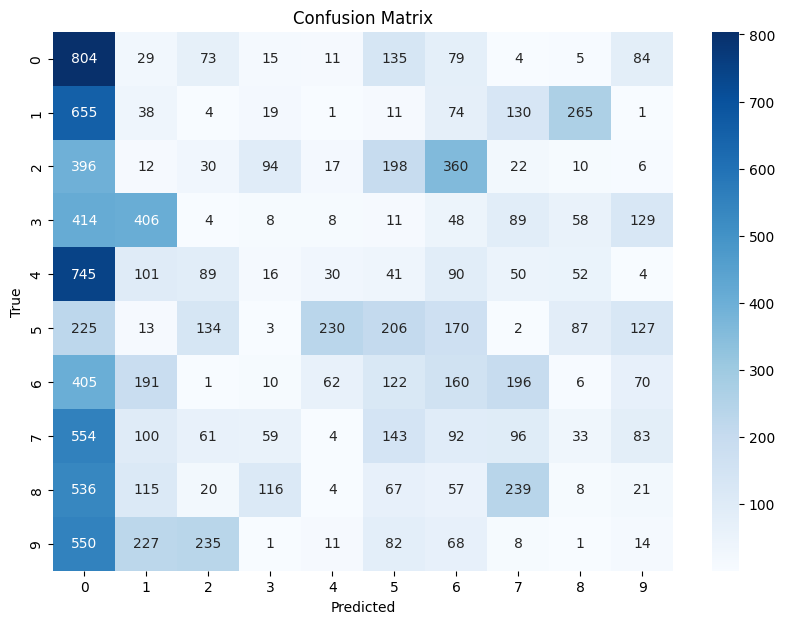

In [4]:
y_pred = rbf_network.predict(X_test)

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


Epoch 0
	Loss: 0.08999999981533646
Epoch 1
	Loss: 0.08999999981533376
Epoch 2
	Loss: 0.08999999981533108
Epoch 3
	Loss: 0.08999999981532836
Epoch 4
	Loss: 0.08999999981532567
Epoch 5
	Loss: 0.08999999981532296
Epoch 6
	Loss: 0.0899999998153203
Epoch 7
	Loss: 0.08999999981531756
Epoch 8
	Loss: 0.08999999981531491
Epoch 9
	Loss: 0.08999999981531218
Epoch 10
	Loss: 0.08999999981530954
Epoch 11
	Loss: 0.0899999998153068
Epoch 12
	Loss: 0.0899999998153041
Epoch 13
	Loss: 0.08999999981530142
Epoch 14
	Loss: 0.08999999981529871
Epoch 15
	Loss: 0.08999999981529601
Epoch 16
	Loss: 0.08999999981529334
Epoch 17
	Loss: 0.08999999981529065
Epoch 18
	Loss: 0.08999999981528795
Epoch 19
	Loss: 0.0899999998152852
Epoch 20
	Loss: 0.08999999981528253
Epoch 21
	Loss: 0.08999999981527981
Epoch 22
	Loss: 0.08999999981527715
Epoch 23
	Loss: 0.08999999981527444
Epoch 24
	Loss: 0.08999999981527178
Epoch 25
	Loss: 0.08999999981526906
Epoch 26
	Loss: 0.08999999981526637
Epoch 27
	Loss: 0.08999999981526366
Epoch 

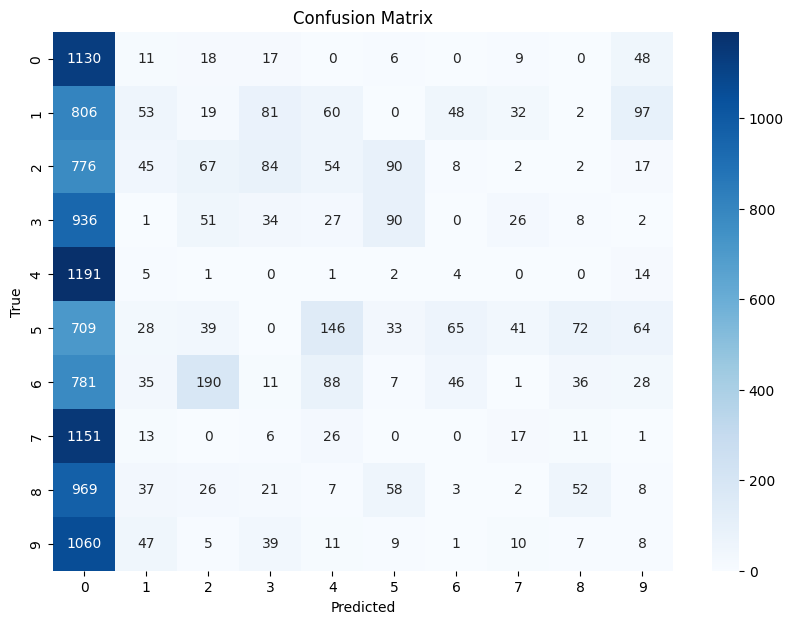

In [5]:
num_rbf_units = 200
num_classes = 10
rbf_network = RBFNetwork(num_rbf_units=num_rbf_units, num_classes=num_classes)

# Train the model
rbf_network.fit(X_train, y_train, learning_rate=0.01, epochs=100)

# Make predictions on the test set
y_pred = rbf_network.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Interpretation
- Very Low Accuracy:  An accuracy of 7.41% is extremely low. It essentially means the model is performing no better than random guessing. If there were 10 classes (as is likely with Kuzushiji-MNIST), random guessing would yield about 10% accuracy.
- Model Issues:  The RBF network, as implemented, is struggling to learn the complex patterns in the Kuzushiji-MNIST dataset. This indicates potential problems with the model's architecture, training process, or hyperparameter settings.
- The loss remains same at around 0.899, which means that :
  - Early convergence: The model reached its best performance quickly.
  - Possible local minimum: The model may be stuck at a suboptimal point.
  - Inadequate learning rate: 0.01 might be too small for meaningful updates.
  - Limited model capacity: The model may be too simple for the problem.
  - Data or problem constraints: Further improvement might be inherently difficult.
  - Good initialization: Starting parameters may have been coincidentally effective.
  - Optimization limitations: The current algorithm may be ineffective for this problem.
---
## Discuss the strengths and limitations of using an RBF network for this (kmnist) dataset.

- Strengths of RBF networks for kmnist:

  - Good at modeling non-linear relationships in data
  - Can focus on specific local features of characters
  - Often train faster than some other neural networks
  - More interpretable results
  - Can handle outliers well

- Limitations:

  - May struggle with high-dimensional data (kmnist images are 784 dimensions)
  - Choosing good center points is challenging but crucial
  - Fixed structure limits adaptability
  - May not scale well to large datasets like kmnist (70,000 images)
  - Lacks built-in feature extraction, unlike CNNs
  - Might not generalize well to unseen character variations
  - Can be memory-intensive
  ---
  ## How does the number of RBF units affect model performance?
  With 100 RBF units the loss on average in all epochs were at 0.089, with 200 RGF units the loss on average is 0.089.
  However, the accuracy with 100 RGF units is 11.62%, with 200 RGF units the accuracy is 12.01%, shows that the accuracy increased with increase of RGF units.
  So, for kmnist dataset, with increase in RGF units the loss increases, in other words the accuracy decreases.